In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import warnings

In [17]:
# Suppress Keras warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Path to the dataset
data_dir = "C:/Users/KIIT/NULL CLASS/Attendance System Model/Smart attendance dataset/"
image_size = (128, 128)  # Resize all images to this size

# Initialize variables
X = []  # Features (images)
y = []  # Labels (names)
label_map = {}  # Map student names to numerical labels

# Load and preprocess images
for idx, student_name in enumerate(os.listdir(data_dir)):
    student_path = os.path.join(data_dir, student_name)
    if not os.path.isdir(student_path):
        continue  # Skip files that are not directories
    
    # Map numerical labels to student names (making sure the correct student name is mapped)
    label_map[idx] = student_name  

    for img_name in os.listdir(student_path):
        img_path = os.path.join(student_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip invalid images
        img = cv2.resize(img, image_size)  # Resize image
        img = img / 255.0  # Normalize to [0, 1]
        X.append(img)
        y.append(idx)  # Append the correct label corresponding to the student

# Convert to NumPy arrays
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# Define the CNN model
model = Sequential([
    Input(shape=(128, 128, 3)),  # Explicitly define the input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images within a range of 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom in or out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill pixels after transformation
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using the augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Using the data generator
    validation_data=(X_test, y_test),  # Validation data
    epochs=10  # Number of epochs
)

# Save the model
model.save('attendance_model_with_augmentation.keras')
print("Model training complete and saved as 'attendance_model_with_augmentation.keras'.")


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.3569 - loss: 1.8384 - val_accuracy: 0.5965 - val_loss: 0.9991
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5220 - loss: 0.9611 - val_accuracy: 0.5965 - val_loss: 0.7546
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.6499 - loss: 0.7516 - val_accuracy: 0.5614 - val_loss: 0.6341
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.6333 - loss: 0.6067 - val_accuracy: 0.4211 - val_loss: 1.2735
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.8060 - loss: 0.5455 - val_accuracy: 1.0000 - val_loss: 0.2797
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.8275 - loss: 0.3878 - val_accuracy: 0.9825 - val_loss: 0.3200
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9781 - loss: 0.3208 - val_accuracy: 1.0000 - val_loss: 0.1703
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9240 - loss: 0.2649 - val_accuracy: 0.8772 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


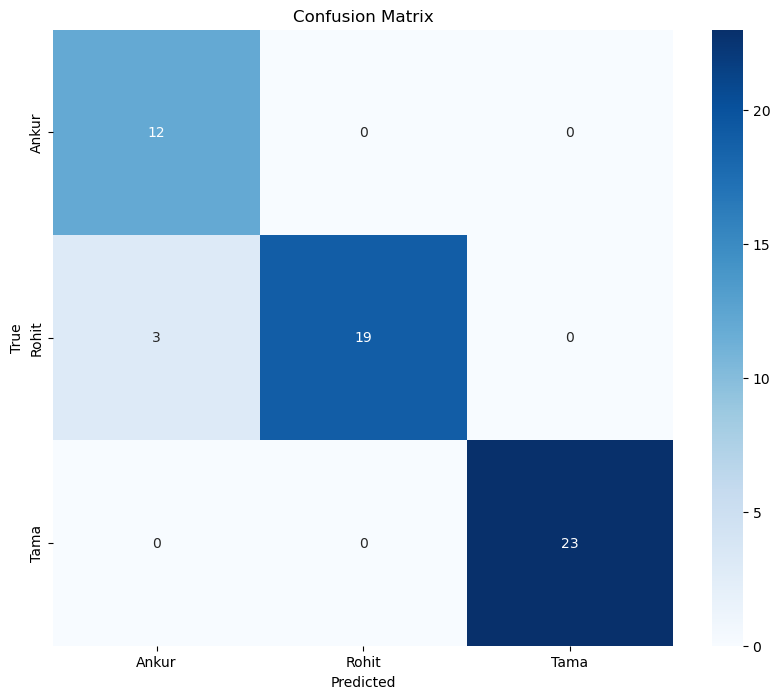

Classification Report:
               precision    recall  f1-score   support

       Ankur       0.80      1.00      0.89        12
       Rohit       1.00      0.86      0.93        22
        Tama       1.00      1.00      1.00        23

    accuracy                           0.95        57
   macro avg       0.93      0.95      0.94        57
weighted avg       0.96      0.95      0.95        57



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

# Convert one-hot encoded y_test back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report (precision, recall, F1-score)
report = classification_report(y_test_classes, y_pred_classes, target_names=label_map.values())
print("Classification Report:\n", report)


In [19]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [20]:
import cv2
import numpy as np

# Preprocess the face image
def preprocess_face(face):
    face_resized = cv2.resize(face, (48, 48))  # Resize to match input size of the model
    face_array = np.expand_dims(face_resized, axis=-1)  # Add channel dimension
    face_array = np.expand_dims(face_array, axis=0)  # Add batch dimension
    face_array = face_array / 255.0  # Normalize pixel values
    return face_array

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model, model_from_json
from datetime import datetime
import pandas as pd

# Load the trained face recognition model
model = load_model('attendance_model.keras')  # Face recognition model

# Load the emotion detection model architecture from JSON
with open('model_a2.json', 'r') as json_file:
    model_json = json_file.read()
emotion_model = model_from_json(model_json)

# Load the weights for the emotion detection model
emotion_model.load_weights('modelWeight.weights.h5')

# Compile the emotion model (optional, based on usage)
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Emotion labels (replace with your model's labels)
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Label map for face recognition
label_map = {0: "Rohit", 1: "Ankur", 2: "Tama"}  # Ensure unique keys for each student

# Initialize attendance data
attendance_data = pd.DataFrame(columns=["Student ID", "Name", "Emotion", "Status", "Timestamp"])

# Set the time range for the attendance system to be active
start_time = "09:30:00"
end_time = "10:00:00"

# Load the face detection model (Haar cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Confidence threshold for face recognition
confidence_threshold = 0.7  # Adjust as needed

def is_within_time_range(start_time, end_time):
    current_time = datetime.now().strftime('%H:%M:%S')
    return start_time <= current_time <= end_time

if is_within_time_range(start_time, end_time):
    print("Attendance system is active.")
    
    # Create a set to track which students have been detected (to mark them present)
    detected_students = set()

    # Start video capture
    cap = cv2.VideoCapture(0)  # Use the default webcam (0)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture video. Exiting.")
            break

        # Convert the frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Crop the face region for face recognition
            face = frame[y:y + h, x:x + w]
            face_resized = cv2.resize(face, (128, 128))  # Resize to match the face model's input
            face_array = np.array(face_resized) / 255.0  # Normalize
            face_array = np.expand_dims(face_array, axis=0)  # Add batch dimension

            # Predict the student's identity
            prediction = model.predict(face_array)
            prediction_confidence = np.max(prediction)  # Get the confidence level of the prediction
            student_index = np.argmax(prediction)

            # Only consider the prediction if it's above the threshold
            if prediction_confidence > confidence_threshold:
                student_name = label_map.get(student_index, "Unknown")
            else:
                student_name = "Unknown"  # If confidence is low, mark as Unknown

            # For emotion detection, use grayscale input and resize to match the emotion model
            face_gray_resized = cv2.resize(gray[y:y + h, x:x + w], (48, 48))  # Resize for emotion model
            face_gray_array = np.array(face_gray_resized) / 255.0  # Normalize
            face_gray_array = np.expand_dims(face_gray_array, axis=0)  # Add batch dimension
            face_gray_array = np.expand_dims(face_gray_array, axis=-1)  # Add channel dimension

            # Predict the emotion
            emotion_prediction = emotion_model.predict(face_gray_array)
            emotion_index = np.argmax(emotion_prediction)
            emotion = emotion_labels[emotion_index]

            # Only mark attendance if the student is recognized and not "Unknown"
            if student_name != "Unknown" and student_index not in detected_students:
                timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                attendance_data = pd.concat([
                    attendance_data,
                    pd.DataFrame({
                        "Student ID": [student_index],
                        "Name": [student_name],
                        "Emotion": [emotion],
                        "Status": ["Present"],
                        "Timestamp": [timestamp]
                    })
                ], ignore_index=True)

                # Add the student to the detected set
                detected_students.add(student_index)

            # Display results on the frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, f"{student_name} ({emotion})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Show the frame
        cv2.imshow('Attendance System', frame)

        # Exit on pressing 'q'
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or cv2.getWindowProperty('Attendance System', cv2.WND_PROP_VISIBLE) < 1:
            break

    # Mark absent students after the session ends
    all_students = set(label_map.keys())  # Set of all students
    absent_students = all_students - detected_students  # Students who were not detected

    for student_index in absent_students:
        student_name = label_map.get(student_index, "Unknown")
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        # Add "Absent" status for each student who wasn't detected
        attendance_data = pd.concat([
            attendance_data,
            pd.DataFrame({
                "Student ID": [student_index],
                "Name": [student_name],
                "Emotion": ["N/A"],
                "Status": ["Absent"],
                "Timestamp": [timestamp]
            })
        ], ignore_index=True)

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

    # Save attendance data to a CSV file
    attendance_data.to_csv("attendance_log.csv", index=False)
    print("Attendance data saved to 'attendance_log.csv'.")

else:
    print("Attendance system is inactive. Please try during the allowed time range.")


Attendance system is active.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━